# Creating a master revenue dataset
### Working with dataset from 'The-Numbers.com'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile 
import sqlite3
%matplotlib inline

In [2]:
#Load 'The Numbers' dataset
tn_df = pd.read_csv('../../data/tn.movie_budgets.csv.gz')
tn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


The dataset has no null values and includes columns for production_budget, domestic_gross and worldwide_gross however, they are all strings. First lets confirm that all numbers are dealing in the same currency ('$')

In [3]:
print("Is the production budget in dollars for all records?: ",tn_df['worldwide_gross'].str.startswith('$').sum() == len(tn_df))
print("Is the domestic gross in dollars for all records?: ",tn_df['domestic_gross'].str.startswith('$').sum() == len(tn_df))
print("Is the worldwide gross in dollars for all records?: ",tn_df['worldwide_gross'].str.startswith('$').sum() == len(tn_df))

Is the production budget in dollars for all records?:  True
Is the domestic gross in dollars for all records?:  True
Is the worldwide gross in dollars for all records?:  True


It looks all the business related data is in dollars. We can safely convert all the numbers without having to do any currency conversions. To ensure we don't lose track, a currency column is created to include the "$" symbol and all numbers are then proceeded to be converted to numbers

In [4]:
#Converting production buget, domestic gross, worldwide gross to numbers, Add currency unit column as a reminder 
#numbers are in $
tn_df['currency'] = '$'
tn_df['production_budget'] = tn_df['production_budget'].str.replace(',','').str.replace('$','').astype(int)
tn_df['domestic_gross'] = tn_df['domestic_gross'].str.replace(',','').str.replace('$','').astype(int)
tn_df['worldwide_gross'] = tn_df['worldwide_gross'].str.replace(',','').str.replace('$','').astype('int64')

Using these we can calculate the net revenue a movie generated

Note: Worldwide gross constitutes domestic gross

In [11]:
#Adding net revenue column and a foreign gross column
tn_df['foreign_gross'] = tn_df['worldwide_gross'] - tn_df['domestic_gross']
tn_df['net_revenue'] = tn_df['worldwide_gross'] - tn_df['production_budget']

Converting release_date to date time

In [12]:
tn_df['release_date'] = pd.to_datetime(tn_df['release_date'])
tn_df['release_year'] = tn_df['release_date'].dt.year
tn_df['release_month'] = tn_df['release_date'].dt.month
tn_df['release_day'] = tn_df['release_date'].dt.day

### Creating a unique key to allow cross referencing our different datasets
Multiple movies have the same title. Having a unique key that we can employ accross our datasets is (pardon the pun) key.
We will use this key to join/merge/search against. This will be a string comprising the movie title and the release year.

In [13]:
tn_df['key_ID'] = tn_df['movie'] + " ("+ tn_df['release_date'].dt.year.astype(str)+")"

Limiting data to post 2012, or essentially last 10 years worth of data. This will help us to emphasize more recent trends. 
For the purpose of visualization we will be using world wide earnings. Dropping records with no world wide earnings data

In [14]:
last_10yrs_df = tn_df[tn_df['release_year']>=2012]
last_10yrs_worldwide_df = last_10yrs_df.drop(last_10yrs_df[last_10yrs_df['worldwide_gross']==0].index)

### Relationship between production budget and gross/net performance
Although a major contributing factor, but not a strong positive corelation

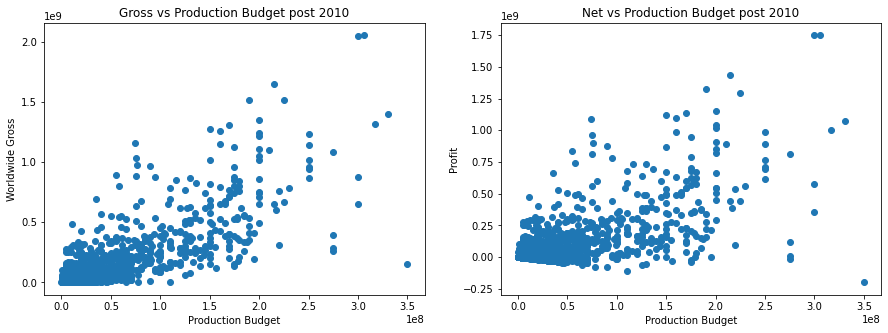

In [15]:
fig,ax = plt.subplots(1,2,figsize = (15,5))

ax[0].scatter(x = last_10yrs_worldwide_df['production_budget'], 
              y = last_10yrs_worldwide_df['worldwide_gross'])
ax[0].set_xlabel('Production Budget')
ax[0].set_ylabel('Worldwide Gross')
ax[0].set_title('Gross vs Production Budget post 2010');

ax[1].scatter(x = last_10yrs_worldwide_df['production_budget'], 
              y = last_10yrs_worldwide_df['net_revenue'])
ax[1].set_xlabel('Production Budget')
ax[1].set_ylabel('Profit')
ax[1].set_title('Net vs Production Budget post 2010');

### Best Release time of the year
Using the revenue data we can try to ascertain the best release windows for movies. From the last 10 years, we can see major revenue being generated during the summer season (May, June, July) and again during holiday season

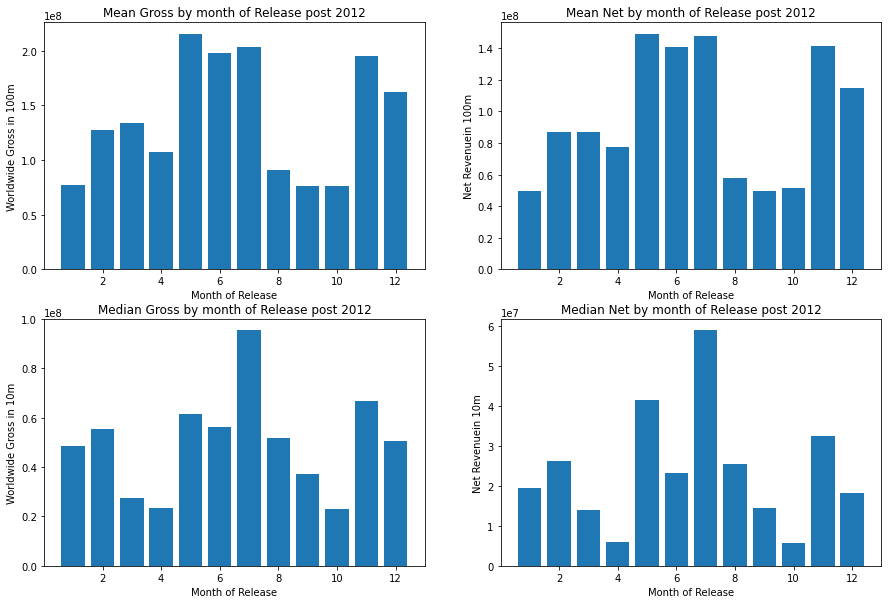

In [10]:
fig,ax = plt.subplots(2,2,figsize = (15,10))

last_10yrs_monthly_df = last_10yrs_worldwide_df.groupby('release_month')

#Graphs for mean gross/net revenue by the month
ax[0,0].bar(x = last_10yrs_monthly_df.mean()['worldwide_gross'].index, 
          height = last_10yrs_monthly_df.mean()['worldwide_gross'])
ax[0,0].set_xlabel('Month of Release')
ax[0,0].set_ylabel('Worldwide Gross in 100m')
ax[0,0].set_title('Mean Gross by month of Release post 2012');

ax[0,1].bar(x = last_10yrs_monthly_df.mean()['net_revenue'].index, 
          height = last_10yrs_monthly_df.mean()['net_revenue'])
ax[0,1].set_xlabel('Month of Release')
ax[0,1].set_ylabel('Net Revenuein 100m')
ax[0,1].set_title('Mean Net by month of Release post 2012');



#Graphs for median gross/net revenue by the month
ax[1,0].bar(x = last_10yrs_monthly_df.median()['worldwide_gross'].index, 
          height = last_10yrs_monthly_df.median()['worldwide_gross'])
ax[1,0].set_xlabel('Month of Release')
ax[1,0].set_ylabel('Worldwide Gross in 10m')
ax[1,0].set_title('Median Gross by month of Release post 2012');

ax[1,1].bar(x = last_10yrs_monthly_df.median()['net_revenue'].index, 
          height = last_10yrs_monthly_df.median()['net_revenue'])
ax[1,1].set_xlabel('Month of Release')
ax[1,1].set_ylabel('Net Revenuein 10m')
ax[1,1].set_title('Median Net by month of Release post 2012');